In [721]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from itertools import combinations
from sklearn.metrics.pairwise import euclidean_distances
import time
from collections import deque
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [722]:
#1. Selecting datasets for clustering
df = pd.read_csv('student_performance.csv')
df

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85
5,6,Olivia,Female,95,30,88,1,High,90
6,7,Daniel,Male,70,8,60,0,Low,62
7,8,Sophia,Female,85,17,77,1,Medium,78
8,9,James,Male,82,12,70,2,Low,72
9,10,Isabella,Female,91,22,86,3,High,88


In [723]:
df2 = pd.read_csv('Mall_Customers.csv')
df2.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [724]:
df.isnull().sum()

StudentID                    0
Name                         0
Gender                       0
AttendanceRate               0
StudyHoursPerWeek            0
PreviousGrade                0
ExtracurricularActivities    0
ParentalSupport              0
FinalGrade                   0
dtype: int64

In [725]:
df2.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [726]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['ParentalSupport'] = LabelEncoder().fit_transform(df['ParentalSupport'])
df.head()

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,1,85,15,78,1,0,80
1,2,Sarah,0,90,20,85,2,2,87
2,3,Alex,1,78,10,65,0,1,68
3,4,Michael,1,92,25,90,3,0,92
4,5,Emma,0,88,18,82,2,2,85


In [727]:
df2['Gender'] = LabelEncoder().fit_transform(df2['Gender'])
df2.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [728]:
#1.1 We have no class labels to remove but we need to drop some non important data
df = df.drop(columns = ['StudentID','Name'])
df.head()


,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,85,15,78,1,0,80
1,0,90,20,85,2,2,87
2,1,78,10,65,0,1,68
3,1,92,25,90,3,0,92
4,0,88,18,82,2,2,85


In [729]:
df2 = df2.drop(columns = ['CustomerID'])
df2.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


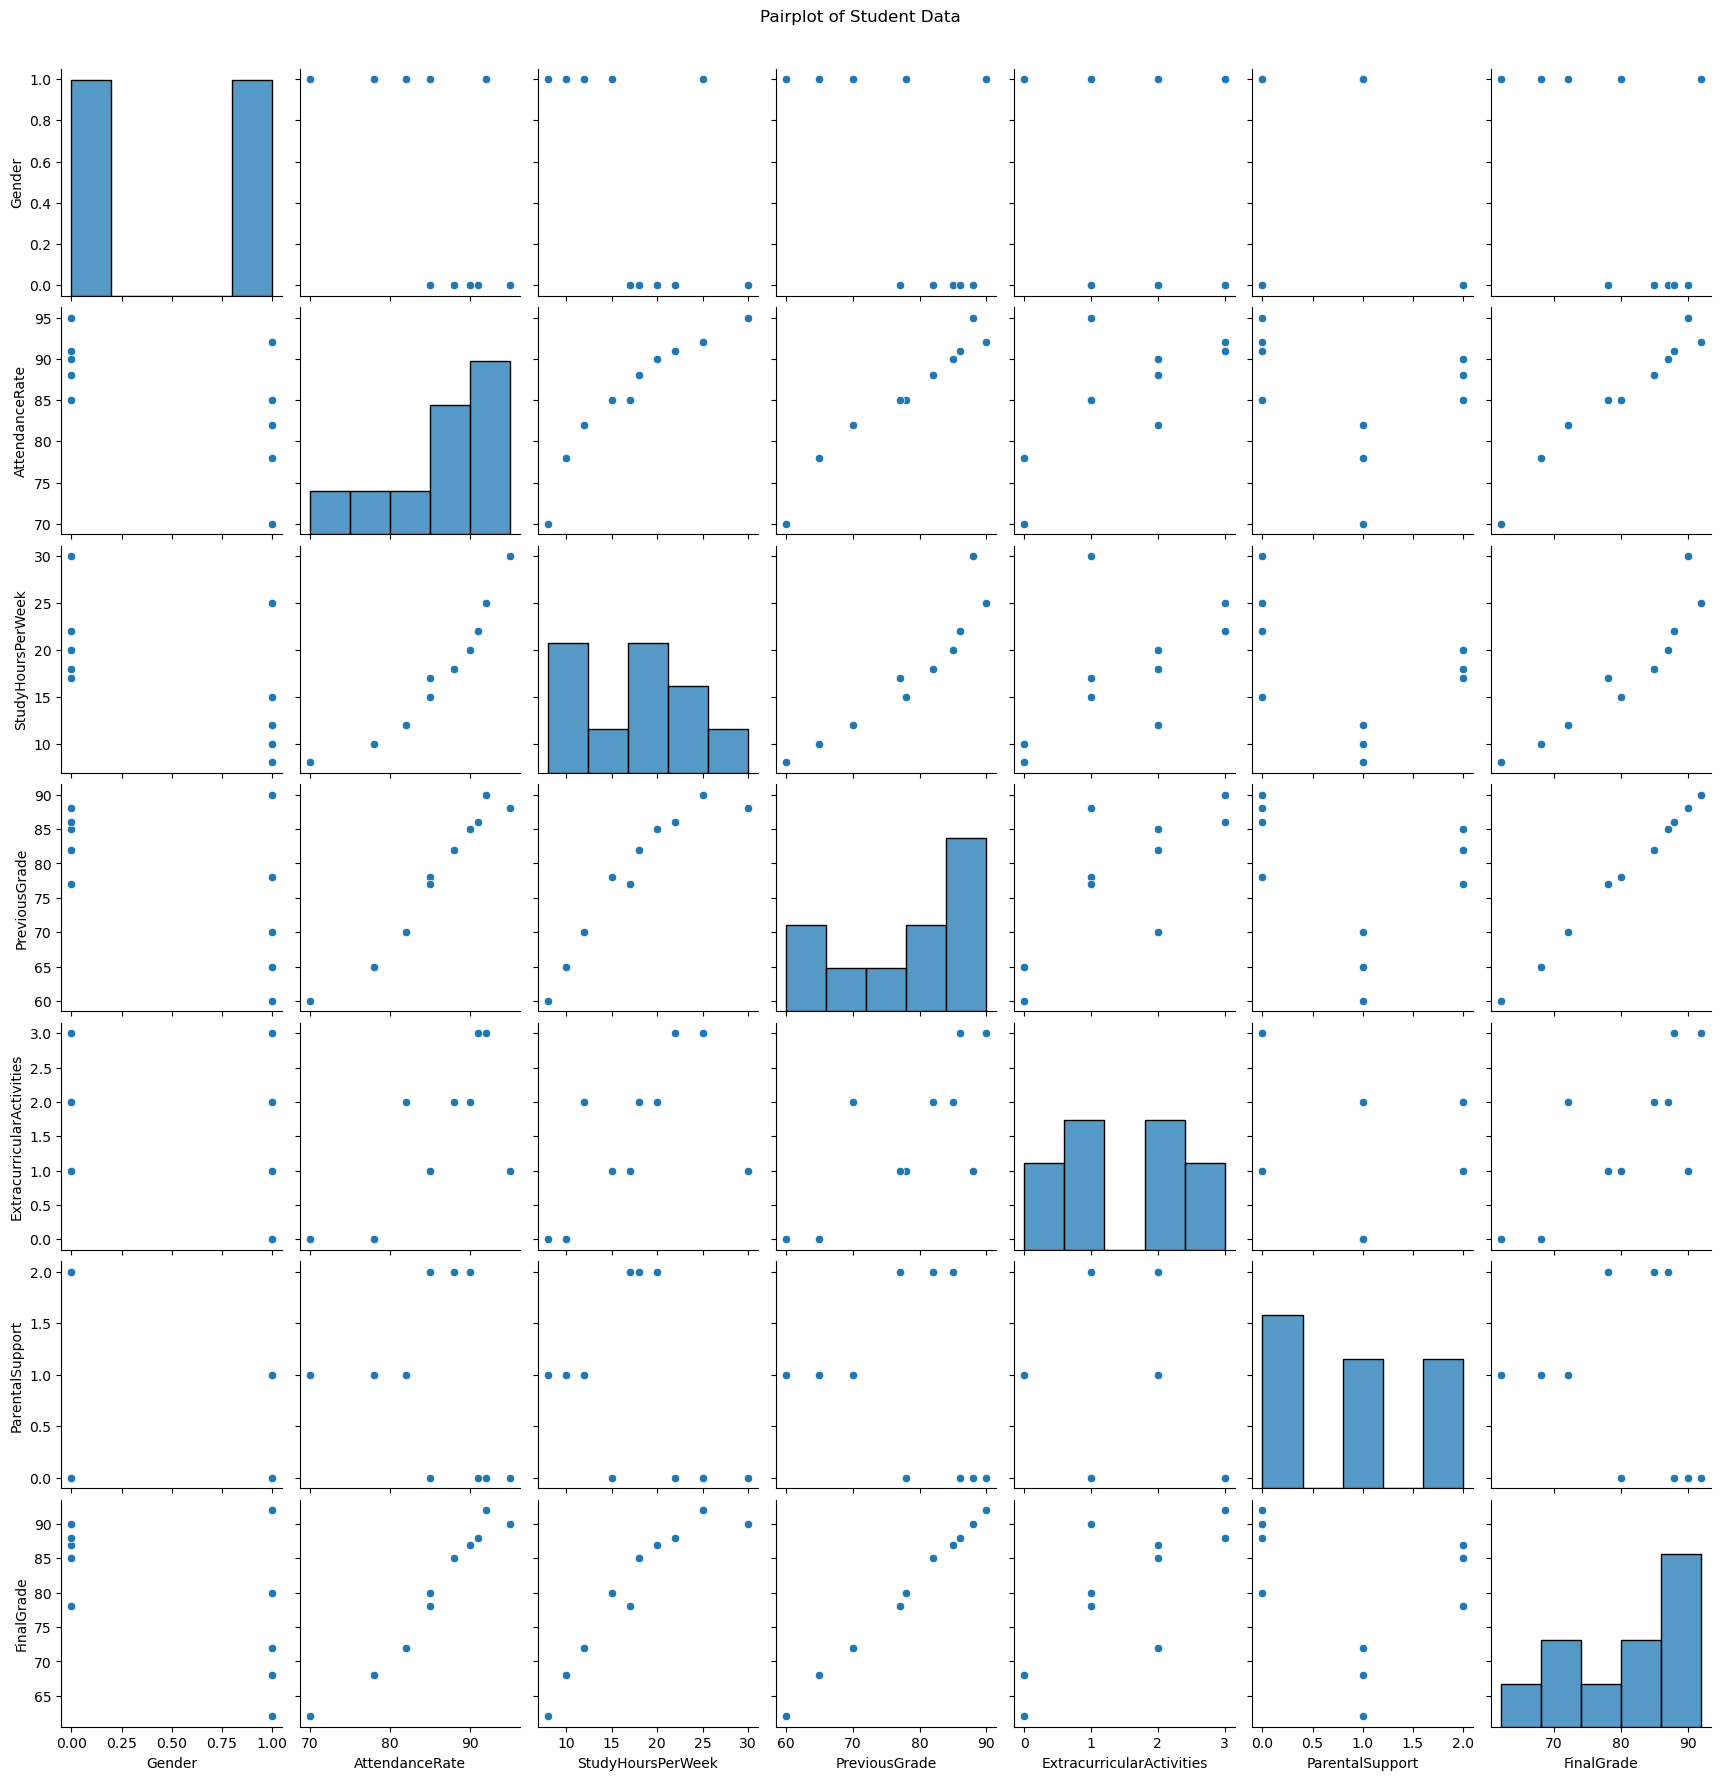

In [730]:
#1.2 Visualizing the data
#first dataset
sns.pairplot(df)
plt.suptitle('Pairplot of Student Data', y=1.02)
plt.show()

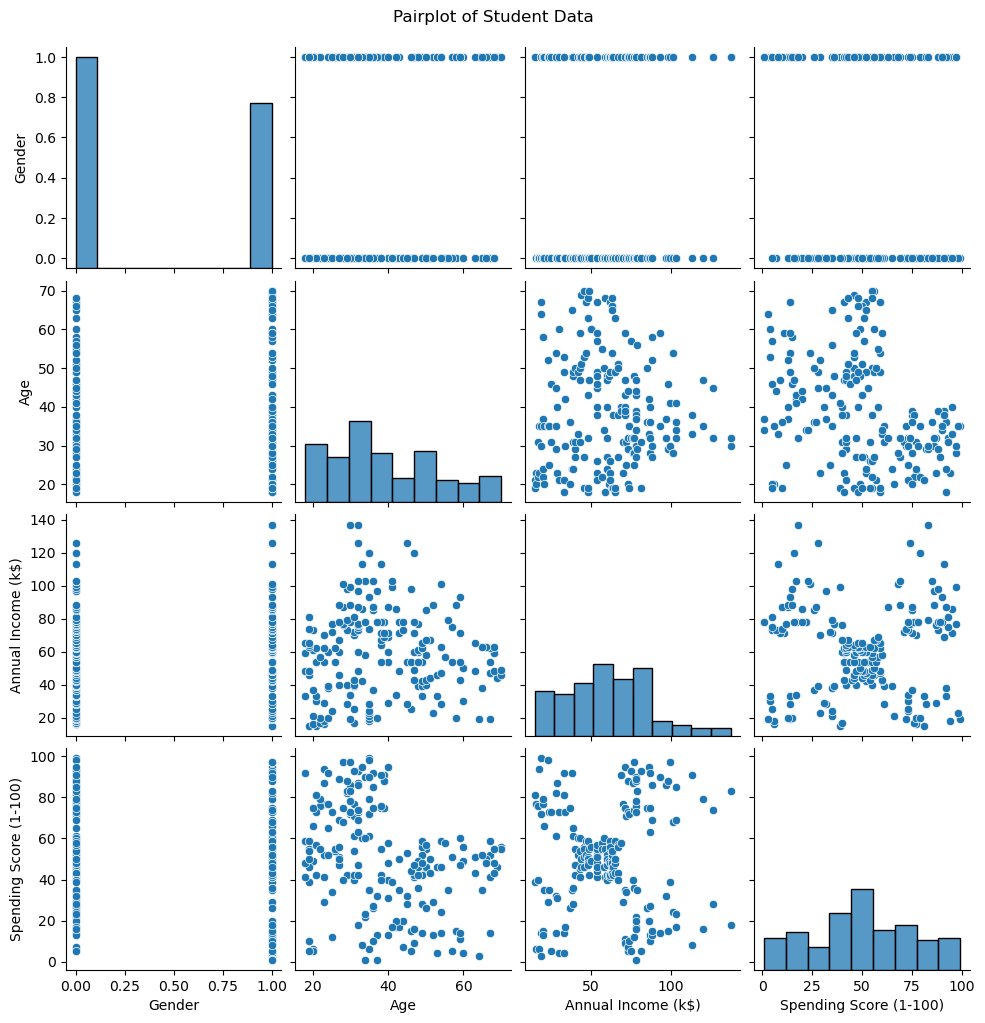

In [731]:
#second dataset
sns.pairplot(df2)
plt.suptitle('Pairplot of Student Data', y=1.02)
plt.show()

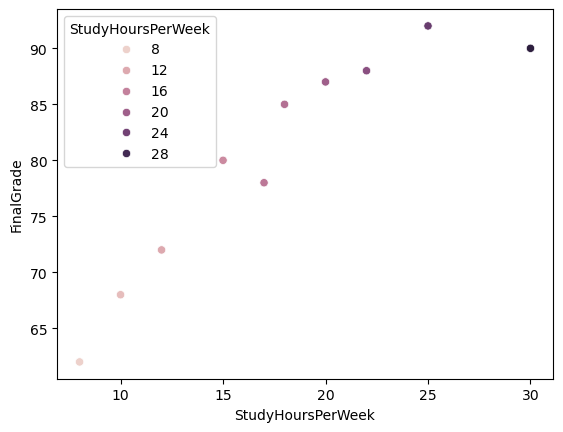

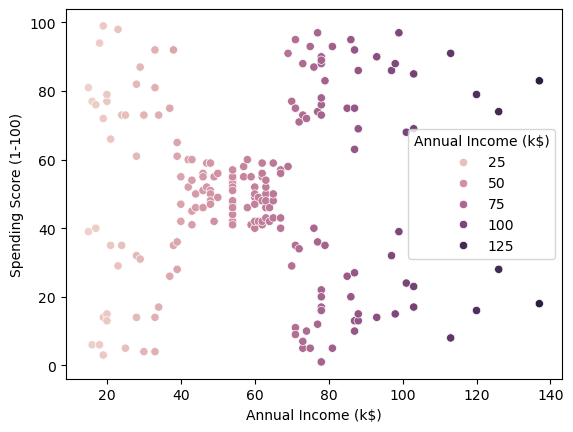

In [732]:
sns.scatterplot(x='StudyHoursPerWeek', y='FinalGrade', data=df, hue='StudyHoursPerWeek')
plt.show()

sns.scatterplot(x=df2.iloc[:,2], y='Spending Score (1-100)', data=df2, hue='Annual Income (k$)')
plt.show()


#1.3 
# for the first dataset we have no clear indicator of the cluster shape. 
#But looking at the shape between FinalGrade and StudyHours 
#it seems to be elongated

#for the second dataset we have somewhat clear clusters. the shape appears to be 
#spherical.

#1.4 
#for the first dataset my assumption is 3 clusters by looking at the graph below
#but for the second dataset 5 clusters will be my assumption

In [733]:
#2 implementing hierarchical algo (Agglomerative clustering)
from scipy.spatial.distance import pdist, squareform

class HierarchicalClustering:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters
        self.labels_ = None

    def fit(self, X):
        # Starting with each point as its own cluster
        n_samples = X.shape[0]
        clusters = {i: [i] for i in range(n_samples)}  #tracking clusters
        distances = squareform(pdist(X)) #doing something i don't understand
        np.fill_diagonal(distances, np.inf)  # this too!

        while len(clusters) > self.n_clusters:
            #closest clusters
            min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)
            c1, c2 = min_dist_idx

            #merging and deleting extra clusters
            clusters[c1].extend(clusters[c2])
            del clusters[c2]

            #updating
            for i in range(n_samples):
                if i != c1 and i in clusters:
                    distances[c1, i] = distances[i, c1] = min(distances[c1, i], distances[c2, i])

            distances[:, c2] = distances[c2, :] = np.inf

        #labeling
        self.labels_ = np.full(n_samples, -1)
        for cluster_id, cluster_points in clusters.items():
            for point in cluster_points:
                self.labels_[point] = cluster_id

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_
    
hc_df = HierarchicalClustering(n_clusters=3)
labels_df = hc_df.fit_predict(df)

hc_df2 = HierarchicalClustering(n_clusters=5)
labels_df2 = hc_df2.fit_predict(df2)

print(f'clusters for dataset 1: {labels_df}')
print(f'clusters for dataset 2: {labels_df2}')




clusters for dataset 1: [0 0 2 0 0 0 6 0 2 0]
clusters for dataset 2: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 123   0 123
   0 123   0 123   0 123   0 123   0 123   0 123   0 123   0 123   0 123
   0 123   0 123   0 123   0 123   0 123   0 123   0 123   0 123   0 123
   0 123   0 123   0 123   0 123   0 123   0 123   0 123   0 123   0 123
   0 123   0 123   0 123   0 123   0 123   0 123 192 123 194 123 194 123
 198 123]


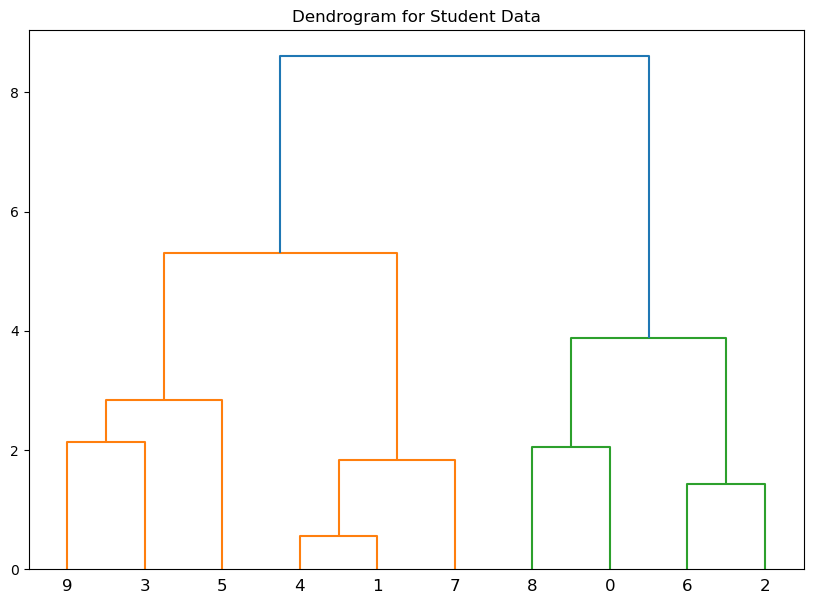

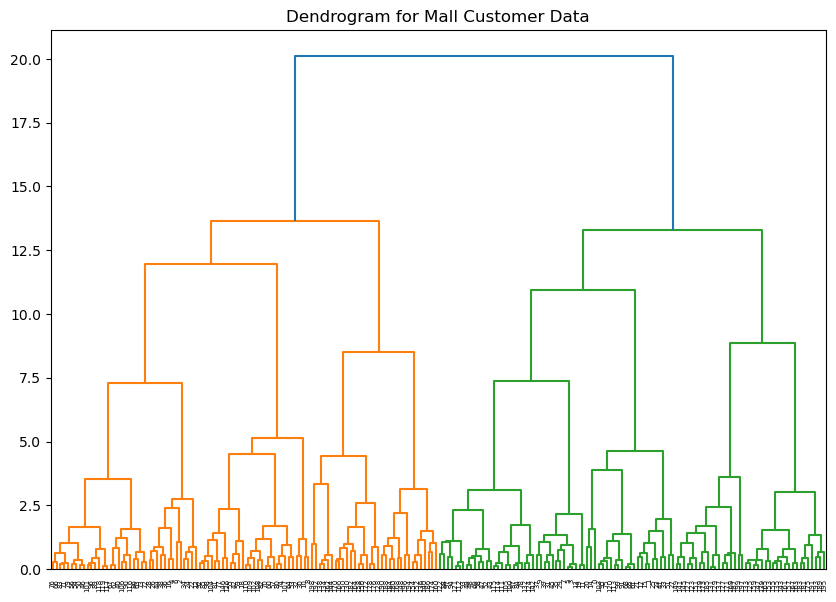

In [734]:
#2.1 constructing dendrograms

#preprocessing data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df2_scaled = scaler.fit_transform(df2)

# Hierarchical clustering
linked_df = linkage(df_scaled, method='ward')
linked_df2 = linkage(df2_scaled,method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked_df,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Student Data')
plt.show() 

plt.figure(figsize=(10, 7))
dendrogram(linked_df2,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Mall Customer Data')
plt.show() 


c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

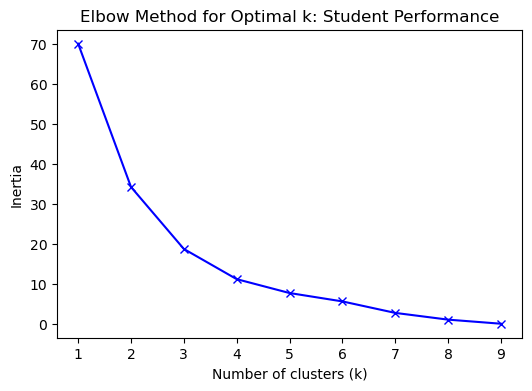

c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

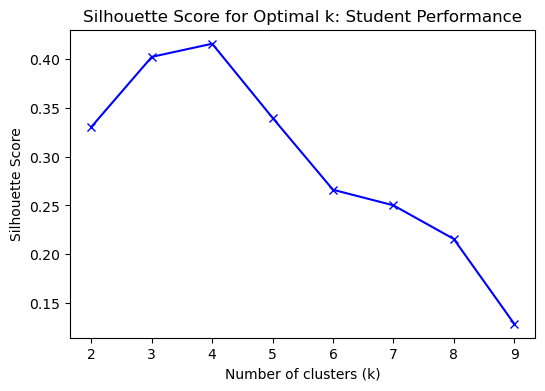

c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

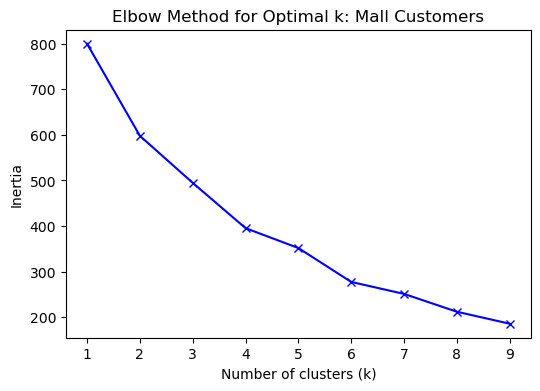

c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

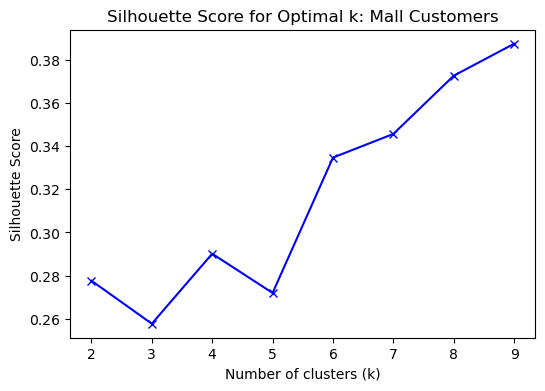

In [735]:
#2.2 determining optimal number of clusters

def plot_elbow_method(X,title):
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for Optimal k: {title}')
    plt.show()

from sklearn.metrics import silhouette_score

def calculate_silhouette(X,title):
    sil = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        labels = kmeans.labels_
        sil.append(silhouette_score(X, labels, metric='euclidean'))

    plt.figure(figsize=(6, 4))
    plt.plot(K, sil, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for Optimal k: {title}')
    plt.show()

plot_elbow_method(df_scaled,'Student Performance')
calculate_silhouette(df_scaled ,'Student Performance')

plot_elbow_method(df2_scaled,'Mall Customers')
calculate_silhouette(df2_scaled ,'Mall Customers')

#according to the results 
#for the first dataset 4 clusters seems to be optimal
# as for the second dataset 9 might be optimal (I am not sure.)


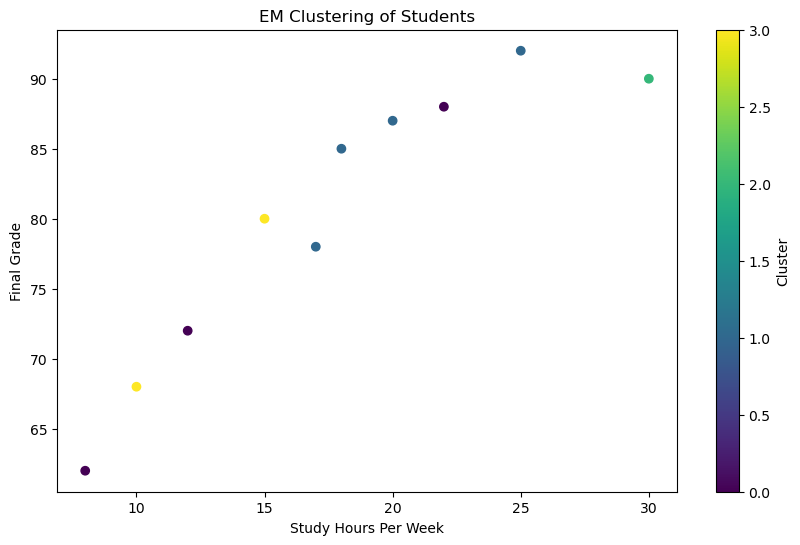

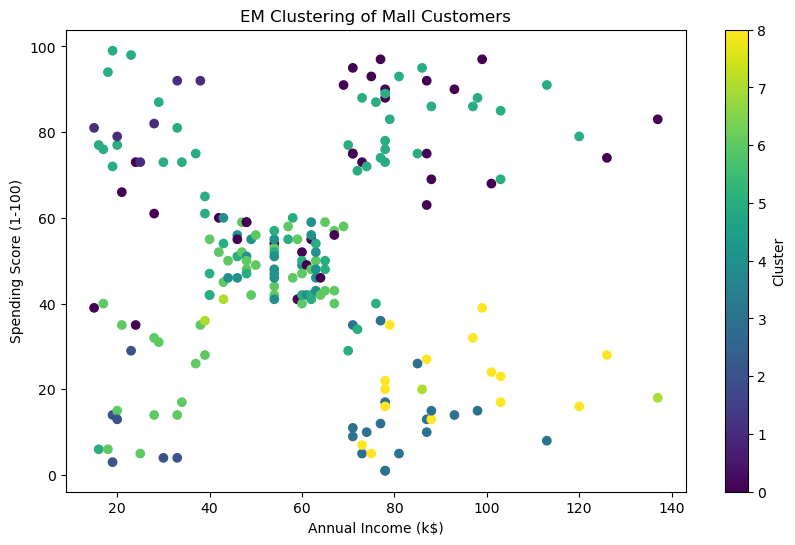

In [742]:
class GaussianMixtureEM:
    def __init__(self, n_components, tol=1e-6, max_iter=100, reg_covar=1e-6):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.reg_covar = reg_covar  # Regularization term for covariance matrices

    def fit(self, X):
        X = X.values

        # Means, covariances, and weights initialization
        np.random.seed(42)
        self.n_samples, self.n_features = X.shape
        self.means = X[np.random.choice(self.n_samples, self.n_components, replace=False)]
        self.covariances = [np.cov(X.T) for _ in range(self.n_components)]
        self.weights = np.ones(self.n_components) / self.n_components

        prev_log_likelihood = -np.inf

        # EM Iterations
        for iteration in range(self.max_iter):
            # E-step remains the same
            responsibilities = np.zeros((self.n_samples, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
            
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

            # M-step: Update the parameters (weights, means, and covariances)
            N_k = responsibilities.sum(axis=0)
            self.weights = N_k / self.n_samples
            self.means = (responsibilities.T @ X) / N_k[:, np.newaxis]

            # Regularize the covariance matrices
            self.covariances = [
                (responsibilities[:, k] * (X - self.means[k]).T) @ (X - self.means[k]) / N_k[k] + self.reg_covar * np.eye(self.n_features)
                for k in range(self.n_components)
            ]

            # Log-likelihood calculation and convergence check
            log_likelihood = np.sum(np.log(np.sum([self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k]) for k in range(self.n_components)], axis=0)))
            
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def fit_predict(self,X):
        n_samples,  _ = X.shape
        likelihoods = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            diff = X - self.means[k].reshape(1,-1)
            maha_dist = np.sum(np.dot(diff, np.linalg.inv(self.covariances[k])) * diff, axis=1)
            likelihoods[:, k] = self.weights[k] * np.exp(-0.5 * maha_dist) / np.sqrt((2 * np.pi) ** X.shape[1] * np.linalg.det(self.covariances[k]))
        
        # Assign each sample to the cluster with the highest likelihood
        predictions = np.argmax(likelihoods, axis=1)
        
        return predictions
    
em_df = GaussianMixtureEM(n_components=4)
em_df.fit(df)

em_df2 = GaussianMixtureEM(n_components=9)
em_df2.fit(df2)

# Get cluster assignments
em_clusters_df = em_df.fit_predict(df.values)
em_clusters_df2 = em_df2.fit_predict(df2.values)

# Add cluster labels to the original dataframe
df['Cluster'] = em_clusters_df
df2['Cluster'] = em_clusters_df2

# Visualize the results for first dataset
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['StudyHoursPerWeek'], df['FinalGrade'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Study Hours Per Week')
plt.ylabel('Final Grade')
plt.title('EM Clustering of Students')
plt.colorbar(scatter, label='Cluster')


plt.show()

# Visualize the results for second dataset
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df2['Annual Income (k$)'], df2['Spending Score (1-100)'], c=df2['Cluster'], cmap='viridis')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('EM Clustering of Mall Customers')
plt.colorbar(scatter, label='Cluster')

plt.show()



    






In [737]:

def average_inter_cluster_distance_GMM(centroids):
    # Calculate pairwise distances between centroids
    distances = [np.linalg.norm(c1 - c2) for c1, c2 in combinations(centroids, 2)]

    # Calculate average distance
    k = len(centroids)
    avg_distance = (2 / (k * (k-1))) * sum(distances)

    return avg_distance

def average_intra_cluster_distance_GMM(data,labels,means):
    # Get cluster means
    cluster_means = means

    unique_labels = np.unique(labels)
    
    intra_cluster_distances = []

    # Calculate intra-cluster distances for each cluster
    for label in unique_labels:
        if label == -1:  # Skip noise points if any
            continue
        cluster_points = data[labels == label]
        
        if cluster_points.shape[0] > 1:  # Ensure there are enough points in the cluster
            cluster_mean = cluster_means[label].reshape(1, -1)  # Ensure shape is (1, num_features)

            # Compute the distances of all points in this cluster to the cluster mean

            distances = euclidean_distances(cluster_points, cluster_mean)
            avg_distance = np.mean(distances)
            intra_cluster_distances.append(avg_distance)
    
    # Return overall average intra-cluster distance
    return np.mean(intra_cluster_distances) if intra_cluster_distances else None

def measure_em_clustering_speed(data,n_components, max_iter):
    start_time = time.time()

    gmm = GaussianMixtureEM(n_components=n_components, max_iter=max_iter)
    gmm.fit(data)
    gmm.fit_predict(data)

    end_time = time.time()
    
    elapsed_time = end_time - start_time
    
    return elapsed_time






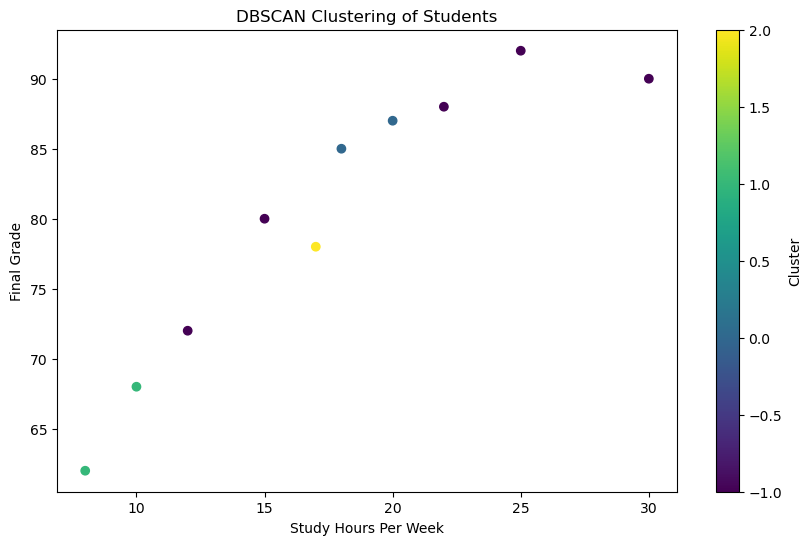

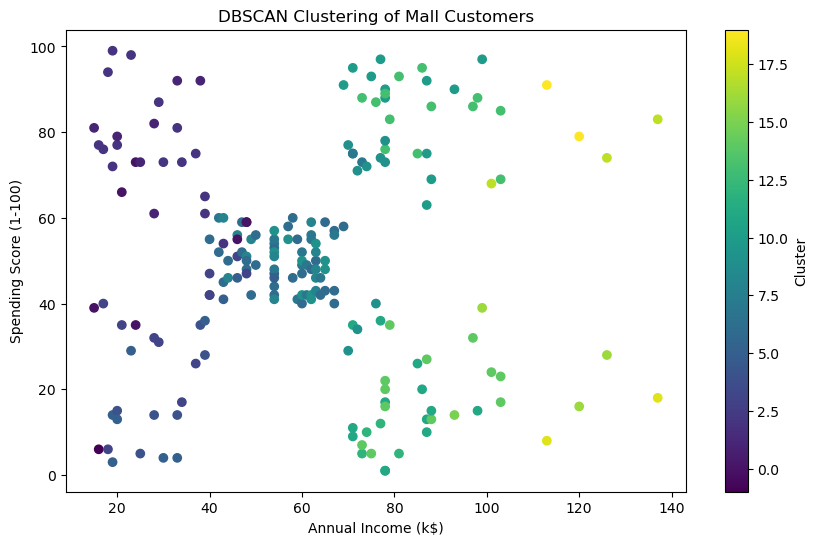

In [738]:
#implementing DBSCAN

class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps  
        self.min_samples = min_samples  
        self.labels_ = None 

    def fit(self, X):
        # Initialize labels (-1 indicates noise)
        self.labels_ = np.full(X.shape[0], -1)
        cluster_id = 0
        
        for i in range(X.shape[0]):
            # If the point is already classified, skip it
            if self.labels_[i] != -1:
                continue

            # Get the neighbors of the point
            neighbors = self.region_query(X, i)
            
            if len(neighbors) < self.min_samples:
                # Mark as noise if not enough neighbors
                self.labels_[i] = -1
            else:
                # Expand the cluster from this point
                self.expand_cluster(X, i, neighbors, cluster_id)
                cluster_id += 1

    def expand_cluster(self, X, point_idx, neighbors, cluster_id):
        # Assign the point to a cluster
        self.labels_[point_idx] = cluster_id
        queue = deque(neighbors)
        
        while queue:
            neighbor_idx = queue.popleft()

            # If the neighbor is noise, change it to a cluster point
            if self.labels_[neighbor_idx] == -1:
                self.labels_[neighbor_idx] = cluster_id

            # If the neighbor is not classified yet, process it
            if self.labels_[neighbor_idx] == -1 or self.labels_[neighbor_idx] == -2:
                self.labels_[neighbor_idx] = cluster_id

                # Get neighbors of this point
                new_neighbors = self.region_query(X, neighbor_idx)

                if len(new_neighbors) >= self.min_samples:
                    # Add the new neighbors to the queue to process
                    queue.extend(new_neighbors)

    def region_query(self, X, point_idx):
        # Find all points within `eps` distance from the given point
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.eps)[0]

    def fit_predict(self, X):
        # Run DBSCAN and return the cluster labels
        self.fit(X)
        return self.labels_
    
db_df = DBSCAN(eps=1.5,min_samples=2)
clusters_df = db_df.fit_predict(df_scaled)

db_df2 = DBSCAN(eps=1.5,min_samples=6)
clusters_df2 = db_df2.fit_predict(df2_scaled)

# Add cluster labels to the original dataframe
df['Cluster'] = clusters_df
df2['Cluster'] = clusters_df2

# Visualize the results dataset 1
plt.figure(figsize=(10, 6))
plt.scatter(df['StudyHoursPerWeek'], df['FinalGrade'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Study Hours Per Week')
plt.ylabel('Final Grade')
plt.title('DBSCAN Clustering of Students')
plt.colorbar(label='Cluster')
plt.show()

# Visualize the results for dataset 2
plt.figure(figsize=(10, 6))
plt.scatter(df2['Annual Income (k$)'], df2['Spending Score (1-100)'], c=df2['Cluster'], cmap='viridis')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DBSCAN Clustering of Mall Customers')
plt.colorbar(label='Cluster')

plt.show()



In [739]:
#average inter cluster distance for DBSCAN

def average_inter_cluster_distance_DBSCAN(data,labels):
    
    unique_labels = set(labels)
    unique_labels.discard(-1)  # Remove noise label (-1)

    if len(unique_labels) < 2:
        # If there are fewer than 2 clusters, return None or 0
        return None

    inter_cluster_distances = []
    
    # Calculate pairwise inter-cluster distances
    for label1 in unique_labels:
        cluster1_points = data[labels == label1]
        for label2 in unique_labels:
            if label1 >= label2:
                continue  # Avoid duplicate and same-cluster comparisons
            cluster2_points = data[labels == label2]
            # Compute pairwise distances between points in cluster1 and cluster2
            distances = euclidean_distances(cluster1_points, cluster2_points)
            avg_distance = np.mean(distances)
            inter_cluster_distances.append(avg_distance)
    
    # Return the average of all inter-cluster distances
    return np.mean(inter_cluster_distances) if inter_cluster_distances else None

#average intra-cluster distance for DBSCAN
def average_intra_cluster_distance_DBSCAN(data,labels):
    unique_labels = set(labels)
    unique_labels.discard(-1)  # Remove noise label (-1)

    if not unique_labels:
        # If there are no valid clusters, return None
        return None

    intra_cluster_distances = []
    
    # Calculate intra-cluster distances for each cluster
    for label in unique_labels:
        cluster_points = data[labels == label]
        if len(cluster_points) > 1:
            # Compute pairwise distances between points in the same cluster
            distances = euclidean_distances(cluster_points)
            # Get the average distance for this cluster (excluding zero distances on the diagonal)
            avg_distance = np.sum(distances) / (len(cluster_points) * (len(cluster_points) - 1))
            intra_cluster_distances.append(avg_distance)

    # Return the overall average intra-cluster distance
    return np.mean(intra_cluster_distances) if intra_cluster_distances else None

#clustering speed
def measure_DBSCAN_clustering_speed(data,eps=0.5, min_samples = 5):
    # Start the timer
    start_time = time.time()
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    
    # Stop the timer
    end_time = time.time()
    
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    
    return elapsed_time




In [743]:
#4. calculating distances for each algorithm

#average intera cluster distance dataset 1
a_intra_c_d_GMM = average_intra_cluster_distance_GMM(df,em_clusters_df,em_df.means)
a_intra_c_d_DBSCAN = average_intra_cluster_distance_DBSCAN(df,clusters_df)

#average intera cluster distance dataset 2
a_intra_c_d_GMM_df2 = average_intra_cluster_distance_GMM(df2,em_clusters_df2,em_df2.means)
a_intra_c_d_DBSCAN_df2 = average_intra_cluster_distance_DBSCAN(df2,clusters_df2)

#average inter cluster distances dataset 1
a_inter_c_d_GMM = average_inter_cluster_distance_GMM(em_df.means)
a_inter_c_d_DBSCAN = average_inter_cluster_distance_DBSCAN(df,em_clusters_df)

#average inter cluster distances dataset 2
a_inter_c_d_GMM_df2 = average_inter_cluster_distance_GMM(em_df2.means)
a_inter_c_d_DBSCAN_df2 = average_inter_cluster_distance_DBSCAN(df2,em_clusters_df2)

#clustering speed dataset 1
clustering_speed_GMM = measure_em_clustering_speed(df, n_components=4, max_iter= 100)
clustering_speed_DBSCAN = measure_DBSCAN_clustering_speed(df_scaled,eps=1.5, min_samples=2)

#clustering speed dataset 2
clustering_speed_GMM_df2 = measure_em_clustering_speed(df2, n_components=9, max_iter= 100)
clustering_speed_DBSCAN_df2 = measure_DBSCAN_clustering_speed(df2_scaled,eps=1.5, min_samples=6)



In [675]:
#using reference algorithms 

#applying EM reference for dataset 1
em_ref_df = GaussianMixture(n_components=4, random_state=42)
em_ref_df.fit(df)
labels_df = em_ref_df.fit_predict(df)

#applying EM reference for dataset 1
em_ref_df2 = GaussianMixture(n_components=9, random_state=42)
em_ref_df2.fit(df2)
labels_df2 = em_ref_df2.fit_predict(df2)

#applying DBSCAN reference for dataset 2
db_ref_df = DBSCAN(eps=1.5,min_samples=2)
lables_df = db_ref_df.fit_predict(df_scaled)

#applying DBSCAN reference for dataset 2
db_ref_df2 = DBSCAN(eps=1.5,min_samples=2)
lables_df2 = db_ref_df2.fit_predict(df2_scaled)

#average intra and inter cluster distance for reference EM algo on dataset 1
a_intra_c_d_RGMM_df =  average_intra_cluster_distance_GMM(df,labels_df,em_ref_df.means_)
a_inter_c_d_RGMM_df = average_inter_cluster_distance_GMM(em_ref_df.means_)

#average intra and inter cluster distance for reference EM algo on dataset 2
a_intra_c_d_RGMM_df2 =  average_intra_cluster_distance_GMM(df2,labels_df2,em_ref_df2.means_)
a_inter_c_d_RGMM_df2 = average_inter_cluster_distance_GMM(em_ref_df2.means_)

#average intra and inter cluster distance for reference DBSCAN algo on dataset 1
a_inter_c_d_RDBSCAN_df = average_inter_cluster_distance_DBSCAN(df,labels_df)
a_intra_c_d_RDBSCAN_df = average_intra_cluster_distance_DBSCAN(df,labels_df)

#average intra and inter cluster distance for reference DBSCAN algo on dataset 2
a_inter_c_d_RDBSCAN_df2 = average_inter_cluster_distance_DBSCAN(df2,labels_df2)
a_intra_c_d_RDBSCAN_df2 = average_intra_cluster_distance_DBSCAN(df2,labels_df2)

#clustering speed
def measure_ref_em_clustering_speed(data,n_components):
    start_time = time.time()

    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit_predict(data)

    end_time = time.time()
    
    elapsed_time = end_time - start_time
    
    return elapsed_time

def measure_ref_DBSCAN_clustering_speed(data,eps=0.5, min_samples = 5):
    # Start the timer
    start_time = time.time()
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit_predict(data)
    
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    
    return elapsed_time

#measuring cluster speeds on dataset 1
clustering_speed_RGMM_df = measure_ref_em_clustering_speed(df,n_components=4)
clustering_speed_RDBSCAN_df = measure_ref_DBSCAN_clustering_speed(df_scaled,eps=1.5,min_samples=2)

#measuring cluster speeds on dataset 2
clustering_speed_RGMM_df2 = measure_ref_em_clustering_speed(df2,n_components=9)
clustering_speed_RDBSCAN_df2 = measure_ref_DBSCAN_clustering_speed(df2_scaled,eps=1.5,min_samples=6)



c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mewie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

In [718]:
#6. Comparisons on Student Performance Dataset

metrics = {
    'Metric': [
        'Average Inter-Cluster Distance (EM)',
        'Average Inter-Cluster Distance (DBSCAN)',
        'Average Intra-Cluster Distance (EM)',
        'Average Intra-Cluster Distance (DBSCAN)',
        'Clustering Speed (EM)',
        'Clustering Speed (DBSCAN)'
    ],
    'Implemented Algorithms': [
        a_inter_c_d_GMM,
        a_inter_c_d_DBSCAN,
        a_intra_c_d_GMM,
        a_intra_c_d_DBSCAN,
        clustering_speed_GMM,
        clustering_speed_DBSCAN
    ],
    'Library Algorithm': [
        a_inter_c_d_RGMM_df,
        a_inter_c_d_RDBSCAN_df,
        a_intra_c_d_RGMM_df,
        a_intra_c_d_RDBSCAN_df,
        clustering_speed_RGMM_df,
        clustering_speed_RDBSCAN_df
    ]
}

comparison_table = pd.DataFrame(metrics)
comparison_table

,Metric,Implemented Algorithms,Library Algorithm
0,Average Inter-Cluster Distance (EM),19.425647,26.902738
1,Average Inter-Cluster Distance (DBSCAN),23.592534,27.080414
2,Average Intra-Cluster Distance (EM),14.183474,4.425080
3,Average Intra-Cluster Distance (DBSCAN),8.266281,7.791194
4,Clustering Speed (EM),0.075961,0.171745
5,Clustering Speed (DBSCAN),0.000000,0.000000


In [719]:
#Comparisons on Mall Customers Dataset

metrics_df2 = {
    'Metric': [
        'Average Inter-Cluster Distance (EM)',
        'Average Inter-Cluster Distance (DBSCAN)',
        'Average Intra-Cluster Distance (EM)',
        'Average Intra-Cluster Distance (DBSCAN)',
        'Clustering Speed (EM)',
        'Clustering Speed (DBSCAN)'
    ],
    'Implemented Algorithms': [
        a_inter_c_d_GMM_df2,
        a_inter_c_d_DBSCAN_df2,
        a_intra_c_d_GMM_df2,
        a_intra_c_d_DBSCAN_df2,
        clustering_speed_GMM_df2,
        clustering_speed_DBSCAN_df2
    ],
    'Library Algorithm': [
        a_inter_c_d_RGMM_df2,
        a_inter_c_d_RDBSCAN_df2,
        a_intra_c_d_RGMM_df2,
        a_intra_c_d_RDBSCAN_df2,
        clustering_speed_RGMM_df2,
        clustering_speed_RDBSCAN_df2
    ]
}

comparison_table_df2 = pd.DataFrame(metrics_df2)
comparison_table_df2

,Metric,Implemented Algorithms,Library Algorithm
0,Average Inter-Cluster Distance (EM),48.859014,54.979429
1,Average Inter-Cluster Distance (DBSCAN),58.802527,60.551800
2,Average Intra-Cluster Distance (EM),22.121713,16.726480
3,Average Intra-Cluster Distance (DBSCAN),21.046504,24.016913
4,Clustering Speed (EM),0.142644,0.249322
5,Clustering Speed (DBSCAN),0.002514,0.000997


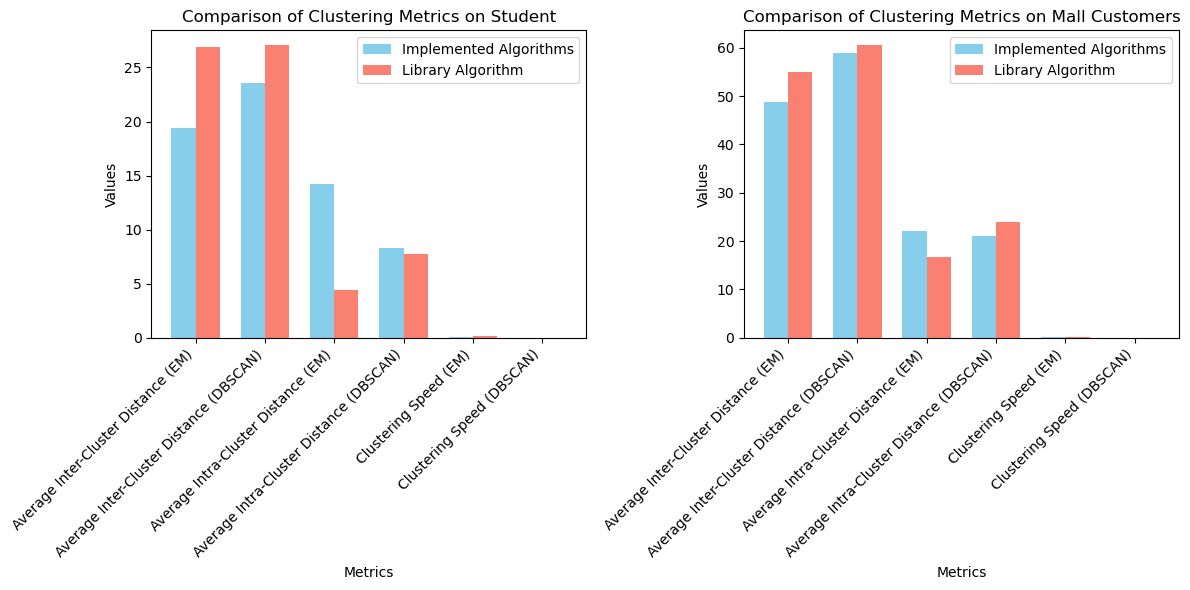

In [720]:
# Plotting comparisons
bar_width = 0.35

comparison_table.set_index('Metric', inplace=True)
x = np.arange(len(comparison_table.index))

comparison_table_df2.set_index('Metric', inplace=True)
x_df = np.arange(len(comparison_table_df2.index))


# Create subplots with 1 row and 2 columns (side by side)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1 (left)
# Create bar plots
ax[0].bar(x - bar_width/2, comparison_table['Implemented Algorithms'], width=bar_width, label='Implemented Algorithms', color='skyblue')
ax[0].bar(x + bar_width/2, comparison_table['Library Algorithm'], width=bar_width, label='Library Algorithm', color='salmon')

# Adding labels and title
ax[0].set_xlabel('Metrics')
ax[0].set_ylabel('Values')
ax[0].set_title('Comparison of Clustering Metrics on Student')
ax[0].set_xticks(x, comparison_table.index, rotation=45, ha='right')
ax[0].legend()

ax[1].bar(x_df - bar_width/2, comparison_table_df2['Implemented Algorithms'], width=bar_width, label='Implemented Algorithms', color='skyblue')
ax[1].bar(x_df + bar_width/2, comparison_table_df2['Library Algorithm'], width=bar_width, label='Library Algorithm', color='salmon')

# Adding labels and title
ax[1].set_xlabel('Metrics')
ax[1].set_ylabel('Values')
ax[1].set_title('Comparison of Clustering Metrics on Mall Customers')
ax[1].set_xticks(x, comparison_table_df2.index, rotation=45, ha='right')
ax[1].legend()




# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

Average Inter-Cluster Distance: Lower values indicate better separation between clusters.
Conclusion: The implemented algorithms (both EM and DBSCAN) have lower average inter-cluster distances compared to their library counterparts, indicating better clustering performance.

Average Intra-Cluster Distance: Lower values indicate that points within the same cluster are closer together.
Conclusion: The library's EM algorithm has the lowest average intra-cluster distance, indicating better compactness within clusters. However, the implemented DBSCAN algorithm has a higher intra-cluster distance compared to the library version.

Clustering Speed: Lower values indicate faster clustering.
Conclusion: Both implemented and library algorithms performed fast but implemented algorithms are a little bit faster.
